In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Морфологична скелетонизация на изображения

## Скелетонизация

### Дефиниция

Скелетонизацията е трансформация, която се извършва над бинаризирани изображения. Тази трансформация се изразява в намаляването на броя на пикселите от изображението до изображение с ширина 1 пиксел, което в голяма степен запазва формата и свързаността на оригиналния регион, но в същото време по-голямата част от пикселите на изображението се изключват. Това получено изображение прилича на скелет, откъдето идва и името на трансформацията. Скелетонът съдържа тези пиксели, които са на еднакво разстояние от границите на изображението.

Скелетонът запазва и показва топологичните и геометричните свойства на изображението - свързаност, топология, дължина, посока и ширина.

Скелетонизацията е необратима операция. При нея част от информацията се губи и в много случаи оригиналното изображение не може точно да бъде възстановено. Нуждата от възстановяване на оригиналното изображение би означавало, че скелетонизацията се използва като компресия, но тя не се ползва за това в практиката.

### Приложение

Скелетонизация е полезна в следните случаи, но не само:
- По-бързо изпълнение на алгоритми, които биха отнели много време върху оригиналното изображения или биха имали трудност при работа с оригиналното изображение
  -  Работа с пръстови отпечатъци. Прилагане на скелетонизация, в комплект с други методи за обработка, може значително да подобри изображението<sup>1</sup>
  <div><img alt="Example of skeletonization of a fingerprint" src="images/skeleton_fingerprint.png" width="1000"/></div>
  - Разпознаване на жестове на ръка. Работата с оригиналното изображение е по-трудна и отнема повече ресурси. Скелетонизацията на пръстите на ръката води до по-лесна работа с тези изображения.

### Пример

Как изглежда едно изображение след като е скелетонизирано най-лесно се разбира с пример<sup>2</sup>:
<div><img alt="Example of skeletonization of a horse binary image" src="images/skeleton_horse.png" width="500"/></div>

Две различни изображения могат да имат еднакъв скелетон<sup>3</sup>, тоест скелетонът не определя еднозначно оригиналното изображение:
<div>
    <img alt="Not unique skeleton - rectangle" src="images/not_unique_skeleton_rect.png" width="250"/>
    <img alt="Not unique skeleton - x shape" src="images/not_unique_skeleton_x.png" width="250"/>
</div>


### Имплементация

В този notebook ще разгледаме имплементация на скелетонизацията чрез морфологични операции. Ще разгледаме алгоритъм, който използва повторно прилагане на морфологичните операции ерозия и дилатация. Ще разгледаме също и алгорими за изтъняване (thinning) и подрязване (pruning).

## Математическа морфология
TODO

## Морфологична операция
Морфологичната операция принадлежи към класа на нелинейните оператори за съседство. Стойността на всеки пиксел се опрделя от стойностите на пиксели, които са в съседство с него. Чрез настройване на размера и формата, определящи кои пиксели са съседни, се конструират морфологични операции, които са чувствителни към специфични форми във входното изображение.

Две от най-базовите морфологични операции са Ерозия и Дилатация. Ерозията е операция, която премахва пиксели от границата на изображения, а дилатацията добавя пиксели към границата.

Съседството се дефинира като структурен елемент - матрица от числата 0 или 1. Пикселът, с който работим, е централният пиксел. Честа практика, за да има такъв централен пиксел, е размерите на структурния елемент да са нечетни числа. При прилагане на операция за съседени пиксели на даден пиксел се приемат само пиксели, които при налагане на структурния елемент върху изображението имат стойност 1. Най-често се използват структурни елементи с размери 3х3 и 5х5. Не е задължително структурният елемент да има квадратна форма. Структурни елементи с размери 3х5 или 7х13 са валидни.

По-долу са показани два структурни елемента с различна форма - елипса и кръст. Всички бели пиксели (стойност 1 в структурния елемент) са съседни на централния пиксел. Всички черни пиксели (стойност 0 в структурния елемент) не са съседни на централния пиксел.

<AxesSubplot:title={'center':'Cross Structure Element'}>

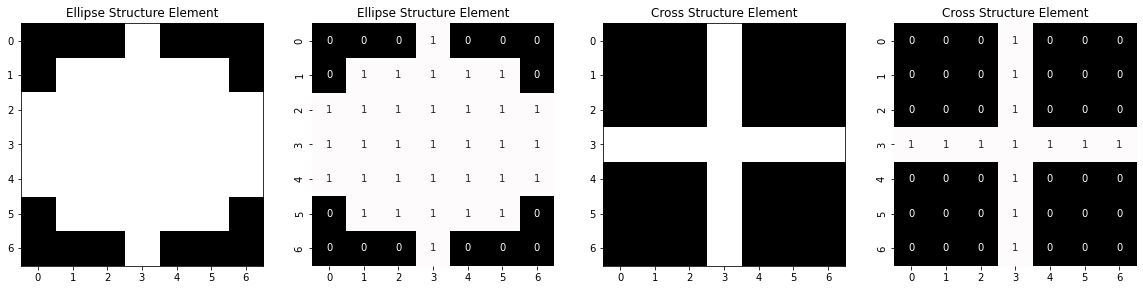

In [7]:
# Ellipse structure element
kernel=(7,7)
figsize=(20,20)
ellipse_se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
cross_se = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel)
rect_se = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=figsize)
ax1.set_title('Ellipse Structure Element')
ax1.imshow(ellipse_se, 'gray')
ax2.set_title('Ellipse Structure Element')
sns.heatmap(ellipse_se, annot=True, cmap='gist_earth', ax=ax2, cbar=False, square=True)

ax3.set_title('Cross Structure Element')
ax3.imshow(cross_se, 'gray')
ax4.set_title('Cross Structure Element')
sns.heatmap(cross_se, annot=True, cmap='gist_earth', ax=ax4, cbar=False, square=True)


## Морфологична операция Ерозия

### Дефиниция
Операцията се представя се със символа ⊖.

Нека **E** е числова матрица и **A** е бинарно изображение в **E**. Ерозия върху изображението **A** със структурен елемент **B** дефинираме като:

$A\ominus B=\{z\in E|B_{{z}}\subseteq A\}$,</br>
където B<sub>z</sub> е транслацията на структурния елемент B с вектор z:</br>
${\displaystyle}B_{z}=\{b+z|b\in B\}, {\displaystyle}\forall z\in E.$

Алтернативно ерозията може да се дефинира и по следния начин:</br>
${\displaystyle}A\ominus B=\bigcap _{{b\in B}}A_{{-b}}$,</br>
където с A<sub>−b</sub> се отбелязва транслацията на A с -b.

Нека с f(x) отбелязваме изображението, а с b(x) - структурния елемент. При ограничение за работа само върху бинаризирани изображения тези дефиниции се свеждат до:</br>
$(f\ominus b)(x)=\min _{{b\in B}}[f(x+b)]$<br/>
$(f\ominus b)(x)=\bigwedge _{{b\in B}}f_{-b}$

Неформално, на всеки пиксел даваме стойност, която е минималната стойност на пиксел в съседство. Това означава, че в бинаризирано изображение пиксели от изображението, които имат за съсед пиксел от фона, ще получат стойност 0 (черен цвят, фон). Основното действие на ерозията се изразява в намаляване (ерозиране) на границите на изображението и увеличаване на дупките в него.

Името на тази операция е взаимствано си от ерозията в реалния свят. Под ерозия в реалния свят разбираме процес, при който под някакво външно въздействие се премахва слой от почвата/скалите. Естественият темп на ерозия се контролира от действието на геоморфологични подбудители като дъжд, износване на скалната основа в реките, брегова ерозия от морето и вълните, ледниково теглене, абразия, наводнения, ветрова абразия, подземни води и свлачища.

### Приложение

TODO 

### Пример

TODO

### Имплементация

TODO

## Морфологична операция Дилатация (Експандиране)

### Дефиниция
Нека **E** е числова матрица и **A** е бинарно изображение в **E**. Дилатация върху изображението **A** със структурен елемент **B** дефинираме като:

$A\oplus B=\{z\in E\mid (B^{s})_{z}\cap A\neq \varnothing \}$,</br>
където $B^{s}=\{x\in E\mid -x\in B\}$:</br>

Алтернативно ерозията може да се дефинира и по следния начин:</br>
$A\oplus B = \bigcup_{b\in B} A_b$,</br>
където с A<sub>b</sub> се отбелязва транслацията на A с b.

Дилатацията е комутативна операция, тоест:</br>
$A\oplus B=B\oplus A=\bigcup _{{a\in A}}B_{a}.$

Нека с f(x) отбелязваме изображението, а с b(x) - структурния елемент. При ограничение за работа само върху бинаризирани изображения тези дефиниции се свеждат до:</br>
$(f\oplus b)(x)=\max _{{b\in B}}[f(x+b)]$<br/>
$(f\oplus b)(x)=\bigvee _{{b\in B}}f_{-b}$

Неформално, на всеки пиксел даваме стойност, която е максималната стойност на пиксел в съсество. Това означава, че в бинаризирано изображение пиксели от фона, които имат за съсед пиксел от изображението, ще получат стойност 1 (бял цвят, изображение). Основното действие на дилатацията се изразява в увеличаване (експандиране) на изображението и запълване на дупките в него.

### Приложение

TODO

### Имплементация

TODO

### Пример

TODO

## Скелетонизация чрез многократно прилагане на Ерозия и Дилатация    

## Източници:
- [1] - https://en.wikipedia.org/wiki/Morphological_skeleton
- [2] - https://medium.com/analytics-vidhya/skeletonization-in-python-using-opencv-b7fa16867331
- [3] - http://www.inf.u-szeged.hu/~palagyi/skel/skel.html